### A notebook for data analysis of the sensitivity analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# Specify the experiment wanted
value_to_vary_name = "earthquake-magnitude"
v = 0.32
replications = 25

# Read the pickle
series_df = pd.read_pickle(f'../results/sensitivity/sens_series_{value_to_vary_name}_{v}_{replications}r_df.pickle')
series_df.head()

,recovered-hospital,recovered-with-help,recovered-unchecked,fraction-called-in,deaths,number-destroyed-streets-spotted,fraction-destroyed-streets-spotted,recovered-hospital,recovered-with-help,recovered-unchecked,...,deaths,number-destroyed-streets-spotted,fraction-destroyed-streets-spotted,recovered-hospital,recovered-with-help,recovered-unchecked,fraction-called-in,deaths,number-destroyed-streets-spotted,fraction-destroyed-streets-spotted
,0,0,0,0,0,0,0,1,1,1,...,23,23,23,24,24,24,24,24,24,24
0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,...,59.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0
1.0,0.0,6.0,136.0,0.034633,77.0,84.0,0.034077,0.0,6.0,120.0,...,64.0,66.0,0.028133,0.0,5.0,106.0,0.034956,84.0,78.0,0.032691
2.0,0.0,17.0,284.0,0.044219,83.0,150.0,0.060852,0.0,11.0,283.0,...,73.0,103.0,0.043905,0.0,9.0,230.0,0.041686,88.0,108.0,0.045264
3.0,0.0,25.0,416.0,0.053767,87.0,205.0,0.083164,0.0,17.0,424.0,...,80.0,142.0,0.060529,0.0,12.0,361.0,0.052177,95.0,147.0,0.061609
4.0,0.0,31.0,563.0,0.063817,92.0,245.0,0.099391,0.0,26.0,561.0,...,84.0,193.0,0.082268,0.0,16.0,506.0,0.061797,97.0,188.0,0.078793


<AxesSubplot: >

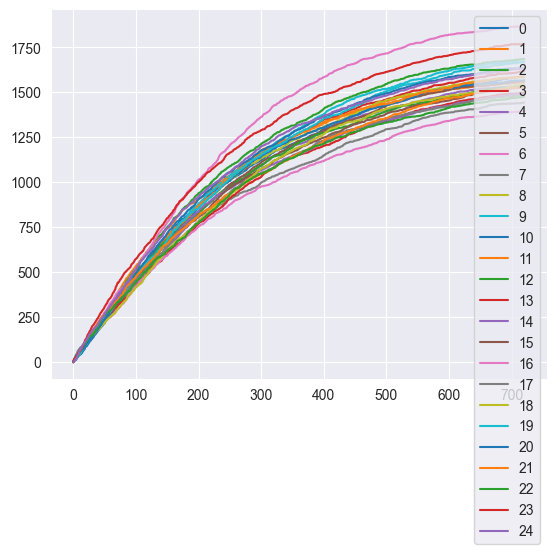

In [3]:
# Plot for one run all the variables
series_df["recovered-with-help"].plot()

<AxesSubplot: >

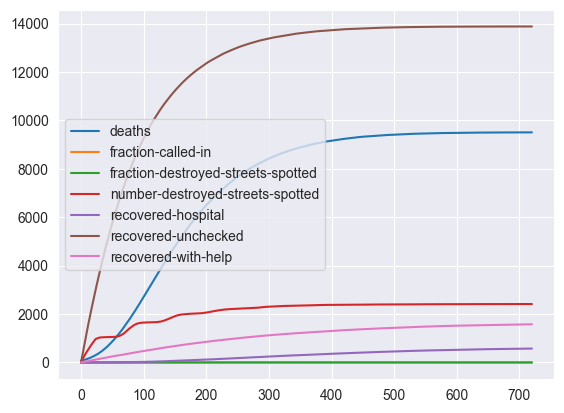

In [4]:
# Take the average of all the runs and plot those
series_df_agg = series_df.groupby(level=[0], axis="columns").mean()
series_df_agg.plot()

## Full sensitivity analysis

### Load data

In [5]:
# Load a dictionary with the default values and if they are rounded or not
default_values = {
    # variable-name: (number, rounded to int or not)
    "call-limit": (True, False),
    "earthquake-magnitude": (0.4, False),
    "amount-ambulances": (40, True),
    "probability-call-112": (1, False),
    "amount-hospitals": (10, True),
    "hospital-capacity": (100, True),
    "hospital-filling-percentage-t0": (60, False),
    "initial-ambulance-search-radius": (5, True),
    "percentage-concrete-buildings": (70, False),
    "high-damage-road-blocked-chance": (10, False),
    "collapsed-road-blocked-chance": (25, False),
    "max-concurrent-calls": (50, True),
    "average-call-time": (2.5, False),
    "amount-drones": (10, True),
    "drone-speed": (0.5, False),
    "drone-range": (45, False),
    "ambulance-reroute-frequency": (5, True),
    # "drone-view-radius": (250, True),
}

In [6]:
# Create a dictionary with all the input values used
input_values = {}
amount_to_vary = [0.8, 1.25]

for var, val in default_values.items():
    input_values[var] = [round(val[0] * v, 5) for v in amount_to_vary]
    if val[1]:
        input_values[var] = [int(v) for v in input_values[var]]
input_values["call-limit"] = [True, False]
input_values

{'call-limit': [True, False],
 'earthquake-magnitude': [0.32, 0.5],
 'amount-ambulances': [32, 50],
 'probability-call-112': [0.8, 1.25],
 'amount-hospitals': [8, 12],
 'hospital-capacity': [80, 125],
 'hospital-filling-percentage-t0': [48.0, 75.0],
 'initial-ambulance-search-radius': [4, 6],
 'percentage-concrete-buildings': [56.0, 87.5],
 'high-damage-road-blocked-chance': [8.0, 12.5],
 'collapsed-road-blocked-chance': [20.0, 31.25],
 'max-concurrent-calls': [40, 62],
 'average-call-time': [2.0, 3.125],
 'amount-drones': [8, 12],
 'drone-speed': [0.4, 0.625],
 'drone-range': [36.0, 56.25],
 'ambulance-reroute-frequency': [4, 6]}

In [7]:
reference = f'../results/sensitivity/sens_series_call-limit_True_{replications}r_df.pickle'

In [8]:
# Read all the pickles into a dictionary of dataframes
dfs = {}
for k, vs in input_values.items():
    for i, v in enumerate(vs):
        dfs[(k, v)] = pd.read_pickle(f'../results/sensitivity/sens_series_{k}_{v}_{replications}r_df.pickle')
        if i == 0:  # Add the reference df after each first value
            dfs[(k, default_values[k][0])] = pd.read_pickle(reference)

### Calculate means

In [9]:
# Create a dictionary with the means
mean_dict = {}
for (k, v), df_t in dfs.items():
    mean_dict[(k, v)] = df_t.iloc[720].groupby(level=0).mean().to_dict()

In [10]:
mean_df = pd.DataFrame.from_dict(mean_dict).T
mean_df

deaths  fraction-called-in  \
call-limit                      True    9894.00                 1.0   
                                False   9768.24                 1.0   
earthquake-magnitude            0.32    9505.36                 1.0   
                                0.4     9894.00                 1.0   
                                0.5    10427.56                 1.0   
amount-ambulances               32     10076.16                 1.0   
                                40      9894.00                 1.0   
                                50      9893.52                 1.0   
probability-call-112            0.8     9861.64                 1.0   
                                True    9894.00                 1.0   
                                1.25    9872.96                 1.0   
amount-hospitals                8       9866.80                 1.0   
                                10      9894.00                 1.0   
                                12      9899.88                 1.0   
hospital-capacity               80      9934.20                 1.0   
                                100     9894.00                 1.0   
                                125     9955.96                 1.0   
hospital-filling-percentage-t0  48.0    9917.08                 1.0   
                                60      9894.00                 1.0   
                                75.0    9949.00                 1.0   
initial-ambulance-search-radius 4       9886.60                 1.0   
                                5       9894.00                 1.0   
                                6       9877.80                 1.0   
percentage-concrete-buildings   56.0   10130.24                 1.0   
                                70      9894.00                 1.0   
                                87.5    9601.88                 1.0   
high-damage-road-blocked-chance 8       9869.72                 1.0   
                                10      9894.00                 1.0   
                                12.5    9927.20                 1.0   
collapsed-road-blocked-chance   20.0    9916.52                 1.0   
                                25      9894.00                 1.0   
                                31.25   9908.16                 1.0   
max-concurrent-calls            40      9969.76                 1.0   
                                50      9894.00                 1.0   
                                62      9871.32                 1.0   
average-call-time               2.0     9938.20                 1.0   
                                2.5     9894.00                 1.0   
                                3.125   9851.64                 1.0   
amount-drones                   8       9936.12                 1.0   
                                10      9894.00                 1.0   
                                12      9976.28                 1.0   
drone-speed                     0.4     9942.28                 1.0   
                                0.5     9894.00                 1.0   
                                0.625   9919.64                 1.0   
drone-range                     36.0    9959.92                 1.0   
                                45      9894.00                 1.0   
                                56.25   9998.24                 1.0   
ambulance-reroute-frequency     4       9941.92                 1.0   
                                5       9894.00                 1.0   
                                6       9967.20                 1.0   

                                       fraction-destroyed-streets-spotted  \
call-limit                      True                             0.994551   
                                False                            0.993046   
earthquake-magnitude            0.32                             0.998247   
                                0.4                              0.994551   
                                0.

In [11]:
mean_df.to_excel("test.xlsx")

### Normalize sensitivity

In [12]:
mean_df_s = mean_df.drop(columns=mean_df.columns[1:4]).T
mean_df_s = mean_df_s.drop(columns="call-limit", level=0)
mean_df_s

earthquake-magnitude                      \
                                    0.32       0.4       0.5   
deaths                           9505.36   9894.00  10427.56   
recovered-hospital                574.76    564.04    575.24   
recovered-unchecked             13878.68  14244.60  14680.56   
recovered-with-help              1577.68   1564.44   1579.52   

                    amount-ambulances                      \
                                   32        40        50   
deaths                       10076.16   9894.00   9893.52   
recovered-hospital             500.32    564.04    627.60   
recovered-unchecked          14342.04  14244.60  14204.24   
recovered-with-help           1454.12   1564.44   1645.84   

                    probability-call-112                     amount-hospitals  \
                                     0.8      True      1.25                8   
deaths                           9861.64   9894.00   9872.96          9866.80   
recovered-hospital                583.36    564.04    573.48           529.20   
recovered-unchecked             14211.56  14244.60  14192.64         14199.92   
recovered-with-help              1569.12   1564.44   1570.44          1375.60   

                     ... amount-drones drone-speed                      \
                     ...            12         0.4       0.5     0.625   
deaths               ...       9976.28     9942.28   9894.00   9919.64   
recovered-hospital   ...        572.88      545.68    564.04    595.84   
recovered-unchecked  ...      14367.32    14296.20  14244.60  14249.64   
recovered-with-help  ...       1563.80     1519.16   1564.44   1616.40   

                    drone-range                      \
                           36.0        45     56.25   
deaths                  9959.92   9894.00   9998.24   
recovered-hospital       580.80    564.04    553.20   
recovered-unchecked    14246.00  14244.60  14346.04   
recovered-with-help     1583.72   1564.44   1540.20   

                    ambulance-reroute-frequency                      
                                              4         5         6  
deaths                                  9941.92   9894.00   9967.20  
recovered-hospital                       548.32    564.04    575.80  
recovered-unchecked                    14224.84  14244.60  14311.28  
recovered-with-help                     1524.72   1564.44   1566.40  

[4 rows x 48 columns]

In [13]:
dev_df = pd.DataFrame(index=mean_df_s.index)
for key in list(input_values.keys())[1::]:
    ref = mean_df_s[key].columns[1]
    for i, column in enumerate(mean_df_s[key].columns):
        if i != 1:
            ratio = column/ref
            dev_df[key, ratio] = (mean_df_s[key][column] - mean_df_s[key][ref]) / mean_df_s[key][ref]
dev_df.columns = pd.MultiIndex.from_tuples(dev_df.columns)
dev_df.T

deaths  recovered-hospital  \
earthquake-magnitude            0.80 -0.039280            0.019006   
                                1.25  0.053928            0.019857   
amount-ambulances               0.80  0.018411           -0.112971   
                                1.25 -0.000049            0.112687   
probability-call-112            0.80 -0.003271            0.034253   
                                1.25 -0.002127            0.016736   
amount-hospitals                0.80 -0.002749           -0.061769   
                                1.20  0.000594            0.046876   
hospital-capacity               0.80  0.004063            0.015744   
                                1.25  0.006262            0.005673   
hospital-filling-percentage-t0  0.80  0.002333            0.042408   
                                1.25  0.005559            0.060918   
initial-ambulance-search-radius 0.80 -0.000748            0.076094   
                                1.20 -0.001637            0.009290   
percentage-concrete-buildings   0.80  0.023877           -0.035175   
                                1.25 -0.029525            0.031203   
high-damage-road-blocked-chance 0.80 -0.002454            0.039288   
                                1.25  0.003356           -0.010638   
collapsed-road-blocked-chance   0.80  0.002276            0.039217   
                                1.25  0.001431           -0.027516   
max-concurrent-calls            0.80  0.007657           -0.044749   
                                1.24 -0.002292            0.033260   
average-call-time               0.80  0.004467            0.051415   
                                1.25 -0.004281           -0.073541   
amount-drones                   0.80  0.004257           -0.018155   
                                1.20  0.008316            0.015673   
drone-speed                     0.80  0.004880           -0.032551   
                                1.25  0.002591            0.056379   
drone-range                     0.80  0.006663            0.029714   
                                1.25  0.010536           -0.019218   
ambulance-reroute-frequency     0.80  0.004843           -0.027870   
                                1.20  0.007398            0.020850   

                                      recovered-unchecked  recovered-with-help  
earthquake-magnitude            0.80            -0.025688             0.008463  
                                1.25             0.030605             0.009639  
amount-ambulances               0.80             0.006840            -0.070517  
                                1.25            -0.002833             0.052031  
probability-call-112            0.80            -0.002319             0.002991  
                                1.25            -0.003648             0.003835  
amount-hospitals                0.80            -0.003137            -0.120708  
                                1.20             0.000205             0.087137  
hospital-capacity               0.80             0.003423            -0.065276  
                                1.25             0.007557             0.081409  
hospital-filling-percentage-t0  0.80            -0.001396            -0.062284  
                                1.25            -0.000258             0.112500  
initial-ambulance-search-radius 0.80            -0.000463             0.034466  
                                1.20            -0.002449            -0.001023  
percentage-concrete-buildings   0.80             0.013995            -0.032932  
                                1.25            -0.021504             0.009946  
high-damage-road-blocked-chance 0.80            -0.000334             0.022219  
                                1.25            -0.004218            -0.012835  
collapsed-road-blocked-chance   0.80             0.000432             0.029352  
                                1.25            -0.004546            -0.025645  
max-concurrent-calls        

### With errorbars

In [231]:
huge_df = pd.DataFrame()
for (k, v), df_t in dfs.items():
    huge_df[(k, v)] = df_t.iloc[720]

huge_df.columns = pd.MultiIndex.from_tuples(huge_df.columns)
huge_df = huge_df.T.sort_index(axis="columns", level=0)
huge_df.T

call-limit          earthquake-magnitude           \
                             True    False                 0.32      0.4   
deaths              0     10391.0  10071.0               9968.0  10391.0   
                    1      9324.0   9995.0               9422.0   9324.0   
                    2      9908.0   9827.0               9603.0   9908.0   
                    3      9874.0   9557.0               9516.0   9874.0   
                    4      9575.0  10285.0               9350.0   9575.0   
...                           ...      ...                  ...      ...   
recovered-with-help 20     1601.0   2186.0               1635.0   1601.0   
                    21     1571.0   2071.0               1529.0   1571.0   
                    22     1567.0   1967.0               1474.0   1567.0   
                    23     1446.0   1788.0               1769.0   1446.0   
                    24     1652.0   2050.0               1632.0   1652.0   

                                amount-ambulances                    \
                            0.5                32       40       50   
deaths              0    9321.0            9799.0  10391.0  10038.0   
                    1   10262.0           10163.0   9324.0  10212.0   
                    2   10682.0           10241.0   9908.0   9844.0   
                    3   10662.0           10249.0   9874.0  10079.0   
                    4   10201.0            9975.0   9575.0   9489.0   
...                         ...               ...      ...      ...   
recovered-with-help 20   1607.0            1658.0   1601.0   1606.0   
                    21   1548.0            1401.0   1571.0   1593.0   
                    22   1207.0            1473.0   1567.0   1693.0   
                    23   1759.0            1587.0   1446.0   1858.0   
                    24   1727.0            1422.0   1652.0   1554.0   

                       probability-call-112           ... amount-drones  \
                                        0.8     True  ...            12   
deaths              0                9593.0  10391.0  ...       10132.0   
                    1               10094.0   9324.0  ...        9732.0   
                    2                9743.0   9908.0  ...       10363.0   
                    3                9479.0   9874.0  ...       10106.0   
                    4                9556.0   9575.0  ...        9925.0   
...                                     ...      ...  ...           ...   
recovered-with-help 20               1453.0   1601.0  ...        1549.0   
                    21               1417.0   1571.0  ...        1669.0   
                    22               1586.0   1567.0  ...        1529.0   
                    23               1727.0   1446.0  ...        1606.0   
                    24               1505.0   1652.0  ...        1283.0   

                       drone-speed                   drone-range           \
                               0.4      0.5    0.625        36.0       45   
deaths              0      10178.0  10391.0   9987.0      9937.0  10391.0   
                    1       9632.0   9324.0   9638.0     10086.0   9324.0   
                    2       9962.0   9908.0  10092.0     10279.0   9908.0   
                    3      10019.0   9874.0   9886.0     10053.0   9874.0   
                    4      10359.0   9575.0   9378.0      9745.0   9575.0   
...                            ...      ...      ...         ...      ...   
recovered-with-help 20      1418.0   1601.0   1635.0      1459.0   1601.0   
                    21      1672.0   1571.0   1466.0      1805.0   1571.0   
                    22      1418.0   1567.0   1831.0      1626.0   1567.0   
                    23      1688.0   1446.0   1616.0      1688.0   1446.0   
                    24      1548.0   1652.0   1516.0      1673.0   1652.0   

                                ambulance-reroute-frequency                    
                          56.25                     

In [ ]:
huge_df2 = pd.DataFrame(index=huge_df.T.index)
for key in list(input_values.keys())[1::]:
    ref = mean_df_s[key].columns[1]
    for i, column in enumerate(mean_df_s[key].columns):
        if i != 1:
            ratio = column/ref
            dev_df[key, ratio] = (mean_df_s[key][column] - mean_df_s[key][ref]) / mean_df_s[key][ref]
dev_df.columns = pd.MultiIndex.from_tuples(dev_df.columns)
dev_df.T

In [213]:
huge_series = huge_df["recovered-hospital"].T.unstack()
huge_series = huge_series.reset_index()
huge_series

,level_0,level_1,level_2,0
0,call-limit,True,0,606.0
1,call-limit,True,1,641.0
2,call-limit,True,2,623.0
3,call-limit,True,3,499.0
4,call-limit,True,4,554.0
...,...,...,...,...
1245,ambulance-reroute-frequency,6,20,609.0
1246,ambulance-reroute-frequency,6,21,715.0
1247,ambulance-reroute-frequency,6,22,568.0
1248,ambulance-reroute-frequency,6,23,635.0


<AxesSubplot: xlabel='level_0', ylabel='0'>

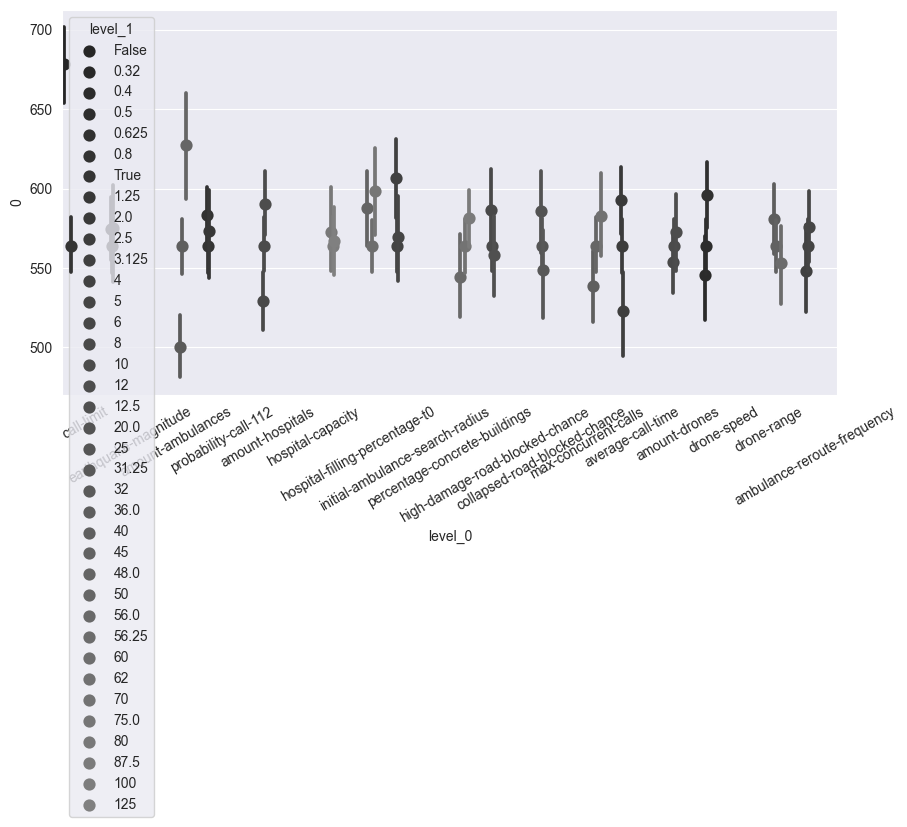

In [230]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
g = sns.pointplot(huge_series, x="level_0", hue="level_1", y=0, estimator='mean', errorbar=('ci', 95), join=False, dodge=True, color=".5", ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g

In [134]:
deaths_df.T

call-limit          earthquake-magnitude                    \
         True    False                 0.32      0.4      0.5   
0     10391.0  10071.0               9968.0  10391.0   9321.0   
1      9324.0   9995.0               9422.0   9324.0  10262.0   
2      9908.0   9827.0               9603.0   9908.0  10682.0   
3      9874.0   9557.0               9516.0   9874.0  10662.0   
4      9575.0  10285.0               9350.0   9575.0  10201.0   
5      9970.0   9655.0               9688.0   9970.0  10068.0   
6      9815.0   9491.0               9287.0   9815.0  11113.0   
7      9899.0   9952.0               9376.0   9899.0  10789.0   
8     10002.0   9677.0               9331.0  10002.0   9870.0   
9      9891.0   9370.0               9360.0   9891.0  10336.0   
10    10182.0   9910.0               9925.0  10182.0  10280.0   
11     9853.0   9376.0               9559.0   9853.0  10641.0   
12    10112.0   9550.0               9618.0  10112.0  11061.0   
13     9968.0   9250.0               9658.0   9968.0  10770.0   
14    10308.0   9385.0               9065.0  10308.0  10629.0   
15     9760.0   9926.0               9697.0   9760.0  10531.0   
16     9683.0   9898.0               9399.0   9683.0  10320.0   
17     9908.0   9821.0               9254.0   9908.0   9849.0   
18     9714.0   9953.0               9628.0   9714.0  10082.0   
19     9827.0  10140.0               9161.0   9827.0  10358.0   
20     9766.0   9224.0               9282.0   9766.0  10619.0   
21     9791.0   9851.0               9736.0   9791.0  10489.0   
22    10117.0  10074.0               9975.0  10117.0  10414.0   
23     9789.0  10289.0               9214.0   9789.0  10520.0   
24     9923.0   9679.0               9562.0   9923.0  10822.0   

   amount-ambulances                   probability-call-112           ...  \
                  32       40       50                  0.8     True  ...   
0             9799.0  10391.0  10038.0               9593.0  10391.0  ...   
1            10163.0   9324.0  10212.0              10094.0   9324.0  ...   
2            10241.0   9908.0   9844.0               9743.0   9908.0  ...   
3            10249.0   9874.0  10079.0               9479.0   9874.0  ...   
4             9975.0   9575.0   9489.0               9556.0   9575.0  ...   
5             9980.0   9970.0   9925.0              10113.0   9970.0  ...   
6            10118.0   9815.0  10100.0               9635.0   9815.0  ...   
7             9964.0   9899.0   9489.0               9849.0   9899.0  ...   
8             9665.0  10002.0   9752.0               9959.0  10002.0  ...   
9            10207.0   9891.0   9441.0              10064.0   9891.0  ...   
10           10426.0  10182.0  10014.0              10329.0  10182.0  ...   
11           10505.0   9853.0  10052.0              10028.0   9853.0  ...   
12            9812.0  10112.0   9897.0               9840.0  10112.0  ...   
13           10023.0   9968.0  10100.0               9299.0   9968.0  ...   
14           10424.0  10308.0   9950.0               9669.0  10308.0  ...   
15            9915.0   9760.0   9841.0               9990.0   9760.0  ...   
16           10246.0   9683.0   9740.0              10014.0   9683.0  ...   
17           10180.0   9908.0  10091.0              10171.0   9908.0  ...   
18            9629.0   9714.0   9771.0               9849.0   9714.0  ...   
19           10397.0   9827.0   9620.0               9674.0   9827.0  ...   
20           10248.0   9766.0   9920.0               9929.0   9766.0  ...   
21           10132.0   9791.0  10357.0               9914.0   9791.0  ...   
22            9729.0  10117.0   9868.0               9849.0  10117.0  ...   
23            9429.0   9789.0   9886.0               9998.0   9789.0  ...   
24           10448.0   9923.0   9862.0               9903.0   9923.0  ...   

   amount-drones drone-speed                   drone-range                    \
              12         0.4      0.5    0.625        36.0       45    56.25   
0      

<bound method _make_class_factory.<locals>.class_factory.<locals>.subcls.set of <AxesSubplot: >>

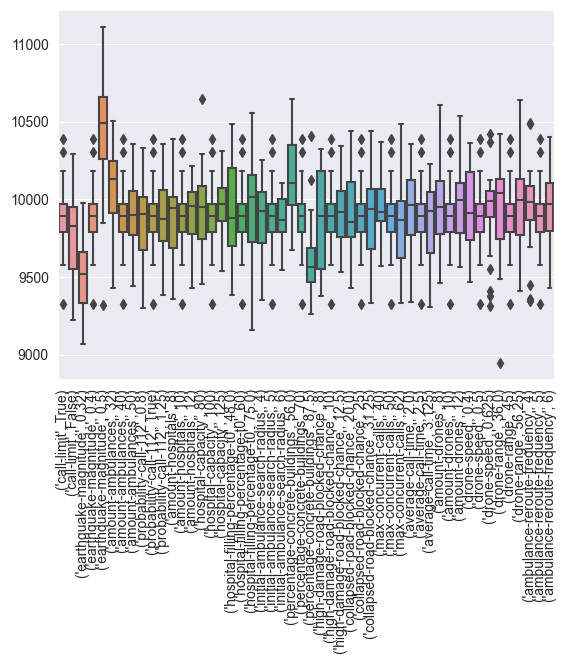

In [136]:
g = sns.boxplot(deaths_df.T)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set

### Extreme values

In [14]:
ev_inputs = [
    "earthquake-magnitude",
    "amount-ambulances",
    "amount-hospitals",
    # "drone-view-radius",
]

In [15]:
# Create a dictionary with all the input values used
ev_input_values = {}
amount_to_vary = [0.2, 1.8]

for var, val in default_values.items():
    if var in ev_inputs:
        ev_input_values[var] = [round(val[0] * v, 5) for v in amount_to_vary]
        if val[1]:
            ev_input_values[var] = [int(v) for v in ev_input_values[var]]
ev_input_values

{'earthquake-magnitude': [0.08, 0.72],
 'amount-ambulances': [8, 72],
 'amount-hospitals': [2, 18]}

In [16]:
# Read all the pickles into a dictionary of dataframes
ev_dfs = {}
for k, vs in ev_input_values.items():
    for i, v in enumerate(vs):
        ev_dfs[(k, v)] = pd.read_pickle(f'../results/sensitivity/sens_series_{k}_{v}_{10}r_df.pickle')

In [23]:
# Create a dictionary with the means
ev_mean_dict = {}
for (k, v), df_t in ev_dfs.items():
    ev_mean_dict[(k, v)] = df_t.iloc[720].groupby(level=0).mean().to_dict()

ev_mean_df = pd.DataFrame.from_dict(ev_mean_dict).T
ev_mean_df

deaths  fraction-called-in  \
earthquake-magnitude 0.08    8448.5                 1.0   
                     0.72   11220.1                 1.0   
amount-ambulances    8.00   10256.6                 1.0   
                     72.00   9754.5                 1.0   
amount-hospitals     2.00   10132.4                 1.0   
                     18.00   9874.7                 1.0   

                            fraction-destroyed-streets-spotted  \
earthquake-magnitude 0.08                             0.999582   
                     0.72                             0.997658   
amount-ambulances    8.00                             0.995463   
                     72.00                            0.990160   
amount-hospitals     2.00                             0.954004   
                     18.00                            0.996063   

                            number-destroyed-streets-spotted  \
earthquake-magnitude 0.08                             2216.4   
                     0.72                             2725.1   
amount-ambulances    8.00                             2468.4   
                     72.00                            2451.7   
amount-hospitals     2.00                             2370.0   
                     18.00                            2462.6   

                            recovered-hospital  recovered-unchecked  \
earthquake-magnitude 0.08                565.6              12847.8   
                     0.72                578.4              15427.0   
amount-ambulances    8.00                218.6              14460.7   
                     72.00               728.2              14103.8   
amount-hospitals     2.00                345.9              14381.8   
                     18.00               609.5              14174.1   

                            recovered-with-help  
earthquake-magnitude 0.08                1521.0  
                     0.72                1599.4  
amount-ambulances    8.00                 996.8  
                     72.00               1818.4  
amount-hospitals     2.00                 713.6  
                     18.00               2012.9

In [24]:
ev_mean_df_s = ev_mean_df.drop(columns=ev_mean_df.columns[1:4]).T
ev_mean_df_s

earthquake-magnitude          amount-ambulances           \
                                   0.08     0.72              8.00     72.00   
deaths                            8448.5  11220.1           10256.6   9754.5   
recovered-hospital                 565.6    578.4             218.6    728.2   
recovered-unchecked              12847.8  15427.0           14460.7  14103.8   
recovered-with-help               1521.0   1599.4             996.8   1818.4   

                    amount-hospitals           
                               2.00     18.00  
deaths                       10132.4   9874.7  
recovered-hospital             345.9    609.5  
recovered-unchecked          14381.8  14174.1  
recovered-with-help            713.6   2012.9

In [25]:
comb_mean_df = pd.concat([ev_mean_df_s, mean_df_s[ev_inputs]],axis=1)
comb_mean_df.sort_index(level=[1], axis="columns", inplace=True)
comb_mean_df

earthquake-magnitude                                \
                                   0.08      0.32      0.40      0.50    
deaths                            8448.5   9505.36   9894.00  10427.56   
recovered-hospital                 565.6    574.76    564.04    575.24   
recovered-unchecked              12847.8  13878.68  14244.60  14680.56   
recovered-with-help               1521.0   1577.68   1564.44   1579.52   

                             amount-hospitals amount-ambulances  \
                       0.72             2.00              8.00    
deaths               11220.1          10132.4           10256.6   
recovered-hospital     578.4            345.9             218.6   
recovered-unchecked  15427.0          14381.8           14460.7   
recovered-with-help   1599.4            713.6             996.8   

                    amount-hospitals                               \
                               8.00      10.00     12.00    18.00   
deaths                       9866.80   9894.00   9899.88   9874.7   
recovered-hospital            529.20    564.04    590.48    609.5   
recovered-unchecked         14199.92  14244.60  14247.52  14174.1   
recovered-with-help          1375.60   1564.44   1700.76   2012.9   

                    amount-ambulances                               
                                32.00     40.00     50.00    72.00  
deaths                       10076.16   9894.00   9893.52   9754.5  
recovered-hospital             500.32    564.04    627.60    728.2  
recovered-unchecked          14342.04  14244.60  14204.24  14103.8  
recovered-with-help           1454.12   1564.44   1645.84   1818.4

In [26]:
ev_dev_df = pd.DataFrame(index=comb_mean_df.index)
for key in list(ev_input_values.keys()):
    ref = comb_mean_df[key].columns[2]
    for i, column in enumerate(comb_mean_df[key].columns):
        ratio = column / ref
        ev_dev_df[key, ratio] = (comb_mean_df[key][column] - comb_mean_df[key][ref]) / comb_mean_df[key][ref]
ev_dev_df.columns = pd.MultiIndex.from_tuples(ev_dev_df.columns)
ev_dev_df.T

deaths  recovered-hospital  recovered-unchecked  \
earthquake-magnitude 0.20 -0.146099            0.002766            -0.098058   
                     0.80 -0.039280            0.019006            -0.025688   
                     1.00  0.000000            0.000000             0.000000   
                     1.25  0.053928            0.019857             0.030605   
                     1.80  0.134031            0.025459             0.083007   
amount-ambulances    0.20  0.036648           -0.612439             0.015171   
                     0.80  0.018411           -0.112971             0.006840   
                     1.00  0.000000            0.000000             0.000000   
                     1.25 -0.000049            0.112687            -0.002833   
                     1.80 -0.014099            0.291043            -0.009884   
amount-hospitals     0.20  0.024095           -0.386746             0.009632   
                     0.80 -0.002749           -0.061769            -0.003137   
                     1.00  0.000000            0.000000             0.000000   
                     1.20  0.000594            0.046876             0.000205   
                     1.80 -0.001951            0.080597            -0.004949   

                           recovered-with-help  
earthquake-magnitude 0.20            -0.027767  
                     0.80             0.008463  
                     1.00             0.000000  
                     1.25             0.009639  
                     1.80             0.022347  
amount-ambulances    0.20            -0.362839  
                     0.80            -0.070517  
                     1.00             0.000000  
                     1.25             0.052031  
                     1.80             0.162333  
amount-hospitals     0.20            -0.543862  
                     0.80            -0.120708  
                     1.00             0.000000  
                     1.20             0.087137  
                     1.80             0.286658

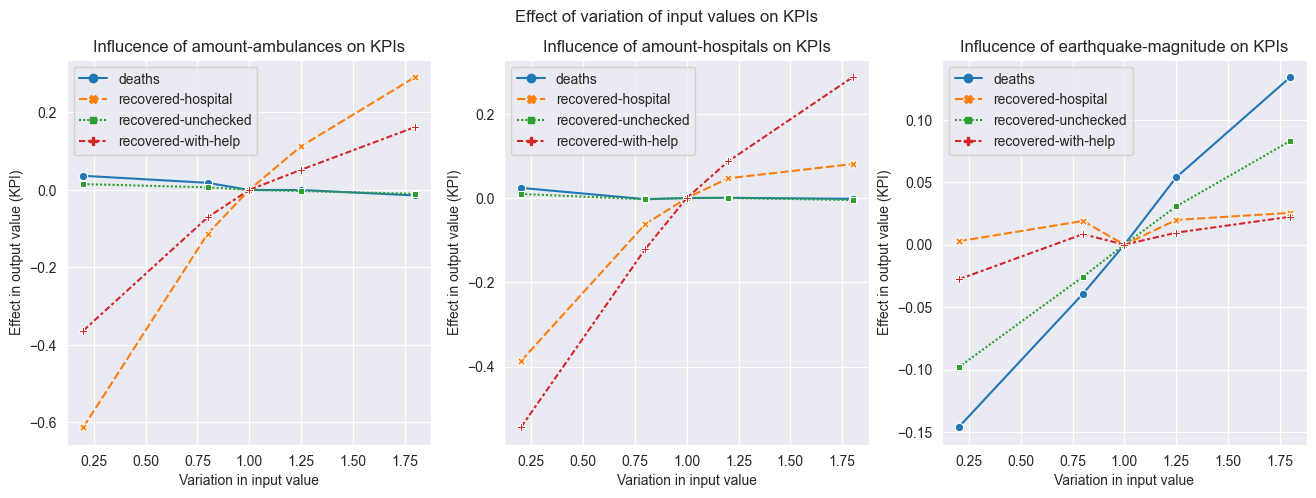

In [27]:
fig, axes = plt.subplots(1,(len(ev_inputs)))
fig.set_size_inches(16,5)
g = {}
for i, in_var in enumerate(ev_inputs):
    g[in_var] = sns.lineplot(ev_dev_df[in_var].T, ax=axes[i], markers=True)
    g[in_var].set_title(f"Influcence of {in_var} on KPIs")
    g[in_var].set_xlabel("Variation in input value")
    g[in_var].set_ylabel("Effect in output value (KPI)")
fig.suptitle("Effect of variation of input values on KPIs")
fig.savefig("../images/extreme_values_plots.svg")